###  Discretized Logistic Mixture 

This notebook demonstrates how to create the Discretized Logistic Mixture used in the [PixelCNN++](https://arxiv.org/abs/1701.05517) and [Parallel Wavenet](https://arxiv.org/abs/1711.10433) using TensorFlow probability.


In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0
        !pip install tfp-nightly
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  False


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


## Mixture of discretized logistics

### A single logistics 
We start with the single logistic function and plot the density. You maybe know this function more by it's Cumulative Probability Distrubution which is used in case of logistic regression.

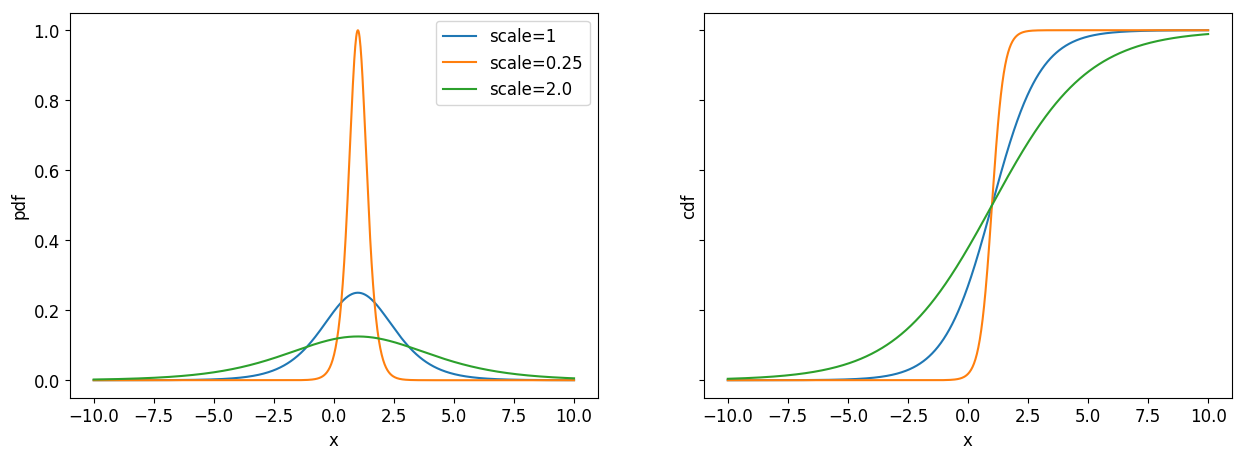

In [3]:
plt.style.use('default')
plt.rcParams.update({'font.size': 12})

vals = np.linspace(-10,10,1000) 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,5))


dist = tfd.Logistic(loc=1, scale=1)
ax1.plot(vals, dist.prob(vals)) 
ax2.plot(vals, dist.cdf(vals)) 

dist = tfd.Logistic(loc=1, scale=0.25)
ax1.plot(vals, dist.prob(vals))
ax2.plot(vals, dist.cdf(vals))

dist = tfd.Logistic(loc=1, scale=2.0)
ax1.plot(vals, dist.prob(vals))
ax2.plot(vals, dist.cdf(vals))


ax1.legend(['scale=1','scale=0.25','scale=2.0'])
ax1.set(xlabel = 'x', ylabel='pdf')

ax2.set(xlabel = 'x', ylabel='cdf')
#ax2.legend(['scale=1','scale=0.5','scale=2.0'])

f.savefig('ch05_logi.pdf')

### Discretization Quantization

The QuantizedDistribution takes a probability distributions and creates a quantized version of it. From the documentation https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution we get:

1. Draw X (from distribution)
2. Set Y <-- ceiling(X)
3. If Y < low, reset Y <-- low
4. If Y > high, reset Y <-- high
5. Return Y

To create integer values which are capted between 0 and $2^{bits} - 1$, we can use the following code. The ceiling of x is the next interger larger (or then x). For example: 

In [4]:
np.ceil(0.00001),np.ceil(0.6),np.ceil(0.999),np.ceil(1.0) #All one

(1.0, 1.0, 1.0, 1.0)

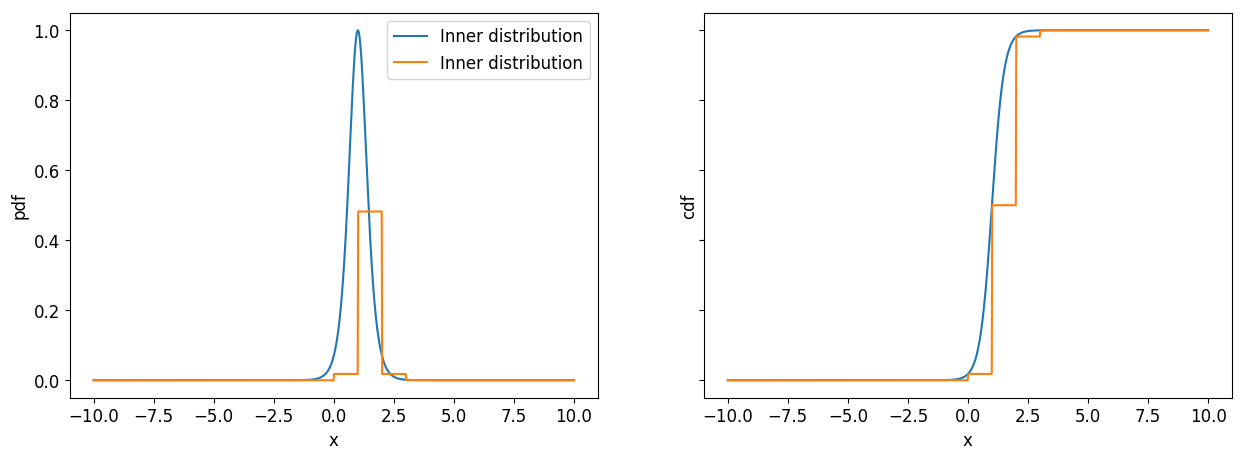

In [5]:
bits = 4
logi = tfd.Logistic(loc=1, scale=0.25)
discretized_logistic_dist = tfd.QuantizedDistribution(logi,low=0., high=2**bits - 1.)
vals = np.linspace(-10,10,1000) 

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,5))

ax1.set(xlabel = 'x', ylabel='pdf')

ax2.set(xlabel = 'x', ylabel='cdf')

ax1.plot(vals, logi.prob(vals)) 
ax1.plot(vals, discretized_logistic_dist.prob(vals)) 

ax2.plot(vals, logi.cdf(vals))
ax2.plot(vals, discretized_logistic_dist.cdf(vals)) 
 
ax1.legend(['Inner distribution','Inner distribution'])

As you can see in the notebook the peak of is not at the position of the inner distribution. This is due to taking the ceil. Luckily, there is a workaround. We shift the distribution 0.5 to the left. Then we have proper rounding:

[Text(0, 0.5, 'cdf'), Text(0.5, 0, 'x')]

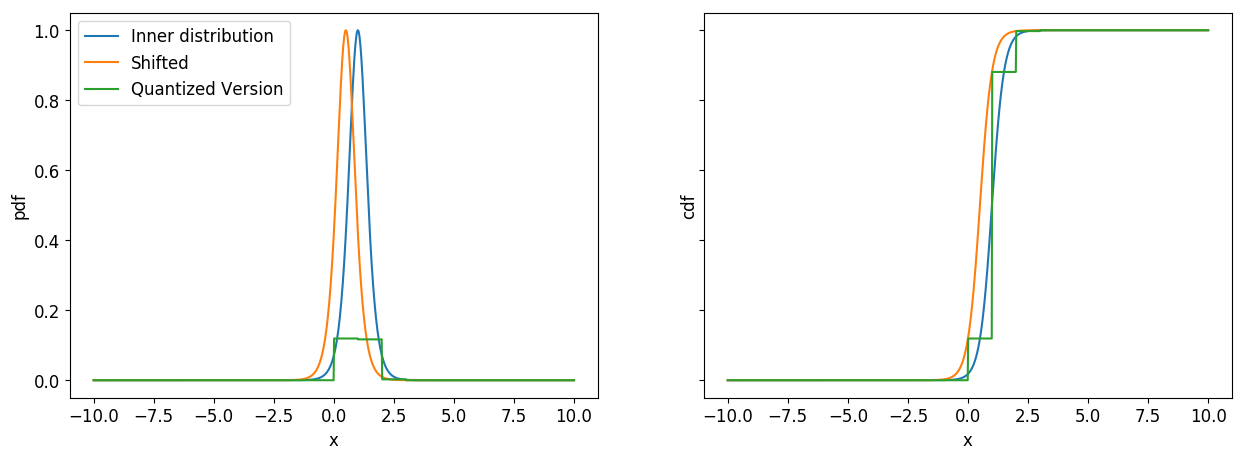

In [6]:
bits = 2

logi = tfd.Logistic(loc=1, scale=0.25)
logis = distribution=tfd.TransformedDistribution(
        distribution=tfd.Logistic(loc=1, scale=0.25),
        bijector=tfb.AffineScalar(shift=-0.5))
discretized_logistic_dist = tfd.QuantizedDistribution(
    logis,
    low=0.,
    high=2**bits - 1.)
    #high=2**16 - 1.)
    
#discretized_logistic_dist = tfd.QuantizedDistribution(logi,low=0., high=2**bits - 1.)
vals = np.linspace(-10,10,1000) 

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,5))



ax1.plot(vals, logi.prob(vals)) 
ax1.plot(vals, logis.prob(vals)) 
ax1.plot(vals, discretized_logistic_dist.prob(vals)) 
ax1.legend(['Inner distribution', 'Shifted','Quantized Version'], loc='upper left')
 
ax2.plot(vals, logi.cdf(vals)) 
ax2.plot(vals, logis.cdf(vals))
ax2.plot(vals, discretized_logistic_dist.cdf(vals))
ax1.set(xlabel = 'x', ylabel='pdf')

ax2.set(xlabel = 'x', ylabel='cdf')

So we can define the following function which can be used for quantisation

In [7]:
def quantize(inner, low=0, bits=4):
    trans = tfd.TransformedDistribution(distribution=inner,bijector=tfb.AffineScalar(shift=-0.5))
    return tfd.QuantizedDistribution(trans,low=0.,high=2**bits - 1.)

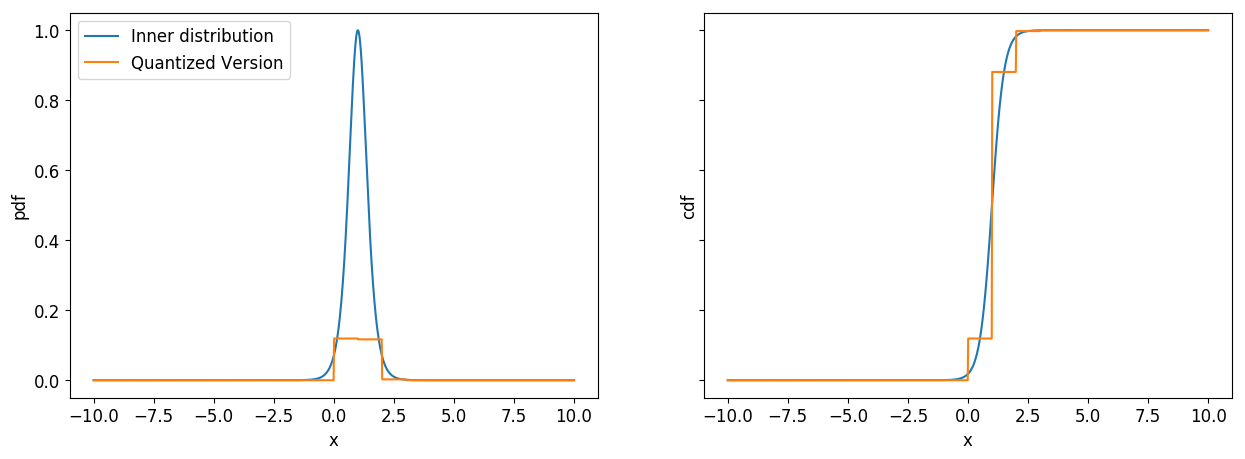

In [8]:
logi = tfd.Logistic(loc=1, scale=0.25)
discretized_logistic_dist = quantize(logi)

    
#discretized_logistic_dist = tfd.QuantizedDistribution(logi,low=0., high=2**bits - 1.)
vals = np.linspace(-10,10,1000) 

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,5))

ax1.plot(vals, logi.prob(vals)) 
ax1.plot(vals, discretized_logistic_dist.prob(vals)) 
ax1.legend(['Inner distribution', 'Quantized Version'], loc='upper left')
 
ax2.plot(vals, logi.cdf(vals)) 
ax2.plot(vals, discretized_logistic_dist.cdf(vals))
ax1.set(xlabel = 'x', ylabel='pdf')
ax2.set(xlabel = 'x', ylabel='cdf')
f.savefig('ch05_quant.pdf')

Haveing the quantized distributions, we can mix them to get more flexible distributions. For this we use the `MixtureOfSameFamily` distribution.  


***TODO mixture.prob(10) is unreasonable high bug? reproduce vals = np.linspace(0,15,1000) 

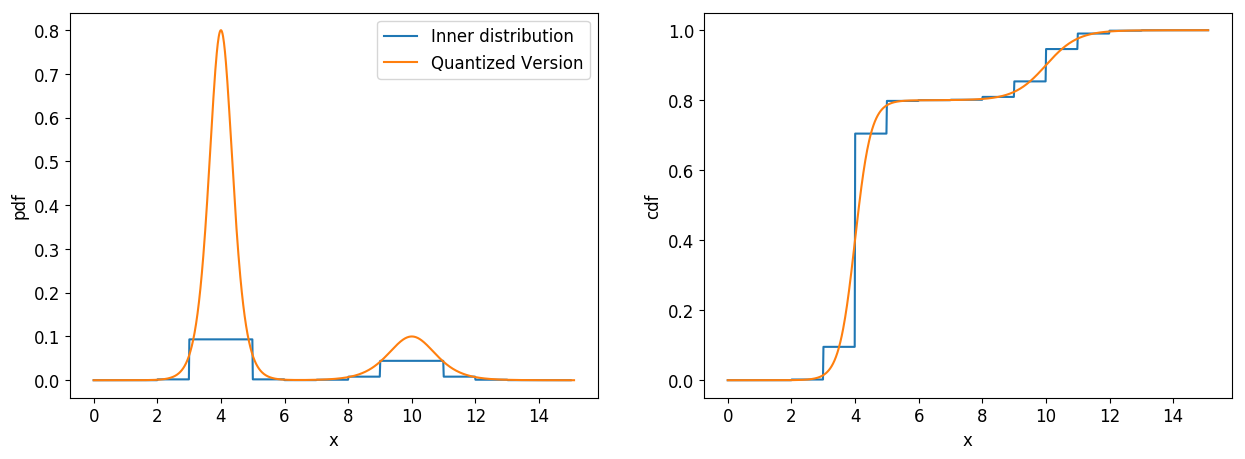

In [9]:
vals = np.linspace(0,15.1,1000) 

locs = (4.0,10.0) #A
scales = (0.25, 0.5) #B 
probs = (0.8, 0.2) #C 

dists = tfd.Logistic(loc=locs, scale=scales) #D
quant = quantize(dists, bits=4) #E
quant_mixture = tfd.MixtureSameFamily( #F
    mixture_distribution=tfd.Categorical(probs=probs),#G
    components_distribution=quant)

#A centers of the two base distributions at 4 and 10
#B Spread of the two base distributions
#C Mixing 80% of the first (at 4.0) and 20% of the second
#D Two independent distributions (batch_shape = 2)
#E The quantized versions of the two independent distributions
#F A mixuture of both distributions 


f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,sharex=True,figsize=(15,5))

mixture = tfd.MixtureSameFamily( #C
    mixture_distribution=tfd.Categorical(probs=probs),#D
    components_distribution=dists)

#ax1.plot(vals, dists.prob(vals)) 
ax1.plot(vals, quant_mixture.prob(vals)) 
ax1.plot(vals, mixture.prob(vals)) 
#ax1.stem(np.linspace(0,15,16), 0.2 * np.ones(16),linefmt='C0--',markerfmt='C0--')
#ax1.legend(['Quantized', 'Weighted Mixture of Quantized Version'], loc='upper left')
 
#ax2.plot(vals, dists.cdf(vals)) 
ax2.plot(vals, quant_mixture.cdf(vals))
ax2.plot(vals, mixture.cdf(vals))

ax1.set(xlabel = 'x', ylabel='pdf')
ax2.set(xlabel = 'x', ylabel='cdf')
ax1.legend(['Inner distribution', 'Quantized Version'], loc='upper right')
f.savefig('ch05_mix.pdf')

### Using the mixture of logistics for a neural netwok

Below you see code how to use the code for a neural network.

In [10]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
#See https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution
def quant_mixture_logistic(out, bits=8, num=3): 
    loc, un_scale, logits = tf.split(out,
                                     num_or_size_splits=num,
                                     axis=-1)
    scale = tf.nn.softplus(un_scale)
    discretized_logistic_dist = tfd.QuantizedDistribution(
    distribution=tfd.TransformedDistribution(
        distribution=tfd.Logistic(loc=loc, scale=scale),
        bijector=tfb.AffineScalar(shift=-0.5)),
    low=0.,
    high=2**bits - 1.)
    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=logits), #logits will be normalized to one
        components_distribution=discretized_logistic_dist)
    return mixture_dist

Definition of the network

In [11]:
inputs = tf.keras.layers.Input(shape=(100,))  
h1 = Dense(10, activation='tanh')(inputs)
out = Dense(6)(h1)
p_y = tfp.layers.DistributionLambda(quant_mixture_logistic)(out)


model = Model(inputs=inputs, outputs=p_y)
#A A dense layer is used without activation. The transformation is done in zero_inf listing 5.l_zi 
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 66        
_________________________________________________________________
distribution_lambda (Distrib ((None,), (None,))        0         
Total params: 1,076
Trainable params: 1,076
Non-trainable params: 0
_________________________________________________________________
